## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd

In [2]:
X_train = pd.read_csv('./yahoo_answers_csv/train.csv', header = None, nrows = 100)

In [4]:
print(X_train)

     0                                                  1  \
0    5  why doesn't an optical mouse work on a glass t...   
1    6       What is the best off-road motorcycle trail ?   
2    3             What is Trans Fat? How to reduce that?   
3    7                         How many planes Fedex has?   
4    7  In the san francisco bay area, does it make se...   
5    5           What's the best way to clean a keyboard?   
6    2     Why do people blush when they are embarrassed?   
7    8  Is Lin Qingxia (aka Brigitte Lin) "the most be...   
8    5                    What is the origin of "foobar"?   
9    2                     How the human species evolved?   
10   4  Who said the statement below and what does it ...   
11   4                How do I find an out of print book?   
12   7  What are some tips on finding a good mortgage ...   
13   5  what's the best way to create a bootable windo...   
14   9  what is the reason for the increasing divorce ...   
15   2                  

In [ ]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
L = 1024 # 1014, 1024 for large 256 for small
NOUT = 2048 # 2048 for large, 1024 for small 
X = tf.placeholder(tf.float32, [None, 70, L])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):    
    conv1 = tf.contrib.layers.conv1d(X, filters=1, kernel_size=7, stride=1, padding='SAME', 
                                   activation_fn=tf.nn.relu, reuse=None, scope="conv1") 
    pool1 = tf.nn.max_pool(value=conv1, pool_size=3, strides=1, padding='VALID', data_format='NHWC', scope="pool1") 
    
    conv2 = tf.contrib.layers.conv1d(pool1, filters=1, kernel_size=7, stride=1, padding='SAME', 
                                   activation_fn=tf.nn.relu, reuse=None, scope="conv2") 
    pool2 = tf.nn.max_pool(value=conv2, pool_size=3, strides=1, padding='VALID', data_format='NHWC', scope="pool2")
    
    conv3 = tf.contrib.layers.conv1d(pool2, filters=1, kernel_size=3, stride=1, padding='SAME', 
                                   activation_fn=tf.nn.relu, reuse=None, scope="conv3") 
    
    conv4 = tf.contrib.layers.conv1d(conv3, filters=1, kernel_size=3, stride=1, padding='SAME', 
                                   activation_fn=tf.nn.relu, reuse=None, scope="conv4") 
    
    conv5 = tf.contrib.layers.conv1d(conv4, filters=1, kernel_size=3, stride=1, padding='SAME', 
                                   activation_fn=tf.nn.relu, reuse=None, scope="conv5") 
    
    conv6 = tf.contrib.layers.conv1d(conv5, filters=1, kernel_size=3, stride=1, padding='SAME', 
                                   activation_fn=tf.nn.relu, reuse=None, scope="conv6") 
    pool6 = tf.nn.max_pool(value=conv6, pool_size=3, strides=1, padding='VALID', data_format='NHWC', scope="pool6")
    
    fc7 = tf.contrib.layers.fully_connected(inputs=tf.contrib.layers.flatten(pool6), num_outputs=NOUT, reuse=None, 
                                      scope="fc7")
    fc8 = tf.contrib.layers.fully_connected(inputs=tf.contrib.layers.flatten(fc7), num_outputs=NOUT, reuse=None, 
                                      scope="fc8")
    
    return fc8

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

In [5]:
## How will I learn TensorFlow?

In [7]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [8]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 7.22 and accuracy of 0.11
Iteration 100: with minibatch training loss = 0.978 and accuracy of 0.31
Iteration 200: with minibatch training loss = 0.805 and accuracy of 0.31
Iteration 300: with minibatch training loss = 0.729 and accuracy of 0.25
Iteration 400: with minibatch training loss = 0.584 and accuracy of 0.38
Iteration 500: with minibatch training loss = 0.49 and accuracy of 0.33
Iteration 600: with minibatch training loss = 0.39 and accuracy of 0.41
Iteration 700: with minibatch training loss = 0.463 and accuracy of 0.36
Epoch 1, Overall loss = 0.738 and accuracy of 0.315


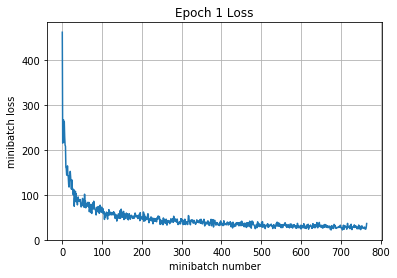

Validation
Epoch 1, Overall loss = 0.433 and accuracy of 0.386


In [9]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [15]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    N, C, H, W = X.shape
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    
    h0, w0, f = (13, 13, 32)
    h2 = int((h0 - 2)/2 + 1)
    w2 = int((w0 - 2)/2 + 1)
    print('h2: ', h2, 'w2: ', w2)
    
    W1 = tf.get_variable("W1", shape=[h2*w2*32, 1024])
    b1 = tf.get_variable("b1", shape=[1024])

    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    c1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    print('c1: ', c1.get_shape())
    r2 = tf.nn.relu(c1) # N x F=32 x H0=13 x W0=13
    b3 = tf.layers.batch_normalization(r2, axis=1, epsilon=0.001, center=True, scale=True, 
                                       beta_initializer=tf.zeros_initializer(), 
                                       gamma_initializer=tf.ones_initializer(),
                                       moving_mean_initializer=tf.zeros_initializer(),
                                       moving_variance_initializer=tf.ones_initializer(),
                                       training=is_training, trainable=True, name='b3', reuse=None)
    # momentum=0.99, beta_regularizer=None, gamma_regularizer=None
    print('b3: ', b3.get_shape())
    m4 = tf.nn.max_pool(value=b3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC', name='m4')
    print('m4: ', m4.get_shape())
    m4_flat = tf.reshape(m4, [-1, int(h2*w2*f)])
    a5 = tf.matmul(m4_flat, W1) + b1
    print('a5: ', a5.get_shape())
    r6 = tf.nn.relu(a5)
    a7 = tf.matmul(r6, W2) + b2
    return a7

with tf.device("/gpu:0"): # run this cell with cpu and then the next cell, then with gpu and then the cell after the next cell
    y_out = complex_model(X,y,is_training)

h2:  6 w2:  6
c1:  (?, 13, 13, 32)
b3:  (?, 13, 13, 32)
m4:  (?, 6, 6, 32)
a5:  (?, 1024)


To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [14]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

10 loops, best of 3: 21.8 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [16]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

10 loops, best of 3: 18.9 ms per loop


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [11]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
# define our loss
total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.RMSPropOptimizer(1e-3) # select optimizer and set learning rate


In [12]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 1.8 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [13]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.77 and accuracy of 0.16
Iteration 100: with minibatch training loss = 1.64 and accuracy of 0.45
Iteration 200: with minibatch training loss = 1.7 and accuracy of 0.39
Iteration 300: with minibatch training loss = 1.18 and accuracy of 0.52
Iteration 400: with minibatch training loss = 1.18 and accuracy of 0.59
Iteration 500: with minibatch training loss = 1.3 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.21 and accuracy of 0.62
Iteration 700: with minibatch training loss = 1.35 and accuracy of 0.45
Epoch 1, Overall loss = 1.49 and accuracy of 0.48


(1.4938755866070184, 0.48046938775510206)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 1.5 with an accuracy of 0.45 to 0.55.

In [14]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.19 and accuracy of 0.594


(1.192084228515625, 0.59399999999999997)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for making how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [19]:
# Feel free to play with this cell
# NOTE DISCUSSED WITH VICTOR CHEUNG -- HE POINTED ME TO THIS PAPER: https://arxiv.org/pdf/1412.6806.pdf
# I read the paper and I followed some of their unique techniques, modifying their "model c".

def my_model(X,y,is_training):
    N, H, W, C = X.shape
    print('N, C, H, W: ', N, C, H, W) 
    
    # setup variables
    '''
    fsz0 = 3
    f0 = 96
    Wconv0 = tf.get_variable("Wconv0", shape=[fsz0, fsz0, 3, f0])
    bconv0 = tf.get_variable("bconv0", shape=[f0])
    h00 = int((int(H) - fsz0) / 2 + 1)
    w00 = int((int(W) - fsz0) / 2 + 1)
    print('h00, w00, f0: ', h00, w00, f0)
    '''
    
    conv_stride = 1
    
    fsz1 = 3
    f1 = 96
    Wconv1 = tf.get_variable("Wconv1", shape=[fsz1, fsz1, 3, f1]) # f0
    bconv1 = tf.get_variable("bconv1", shape=[f1])
    h01 = int((int(H) - fsz1) / conv_stride + 1) # h00
    w01 = int((int(W) - fsz1) / conv_stride + 1) # w00
    print('before maxpool h01, w01, f1: ', h01, w01, f1)
    h01 = int((h01 - 2)/2 + 1)
    w01 = int((w01 - 2)/2 + 1)
    print('after maxpool h01, w01, f1: ', h01, w01, f1)
    
    fsz2 = 3
    f2 = 192
    Wconv2 = tf.get_variable("Wconv2", shape=[fsz2, fsz2, f1, f2])
    bconv2 = tf.get_variable("bconv2", shape=[f2])
    h02 = int((h01 - fsz2) / conv_stride + 1)
    w02 = int((w01 - fsz2) / conv_stride + 1)
    print('before maxpool h02, w02, f2: ', h02, w02, f2)
    h02 = int((h02 - 2)/2 + 1)
    w02 = int((w02 - 2)/2 + 1)
    print('after maxpool h02, w02, f2: ', h02, w02, f2)
    
    fsz3 = 3
    f3 = 192
    Wconv3 = tf.get_variable("Wconv3", shape=[fsz3, fsz3, f2, f3])
    bconv3 = tf.get_variable("bconv3", shape=[f3])
    h03 = int((h02 - fsz3) / conv_stride + 1)
    w03 = int((w02 - fsz3) / conv_stride + 1)
    print('before maxpool h03, w03, f3: ', h03, w03, f3)
    h03 = int((h03 - 2)/2 + 1)
    w03 = int((w03 - 2)/2 + 1)
    print('after maxpool h03, w03, f3: ', h03, w03, f3)
    
    h0, w0, f = (h03, w03, f3) # (h03, w03, f3)
    h2 = h0 # int((h0 - 2)/2 + 1)
    w2 = w0 # int((w0 - 2)/2 + 1)
    print('h2, w2, f: ', h2, w2, f)
    
    W1 = tf.get_variable("W1", shape=[h2*w2*f, 1024])
    b1 = tf.get_variable("b1", shape=[1024])

    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])
    
    # define our graph (e.g. two_layer_convnet)
    
    # CONVOLUTIONAL LAYER
    '''
    c10 = tf.nn.conv2d(X, Wconv0, strides=[1,2,2,1], padding='VALID') + bconv0
    r20 = tf.nn.relu(c10) # N x F=32 x H0=13 x W0=13
    b30 = tf.layers.batch_normalization(r20, axis=1, epsilon=0.001, center=True, scale=True, 
                                       training=is_training, trainable=True, reuse=None)
    print('b30: ', b30.get_shape())
    '''
    
    # CONVOLUTIONAL LAYER
    c11 = tf.nn.conv2d(X, Wconv1, strides=[1,conv_stride,conv_stride,1], padding='VALID') + bconv1 # b30
    b31 = tf.layers.batch_normalization(c11, axis=1, epsilon=0.001, center=True, scale=True, 
                                       training=is_training, trainable=True, reuse=None) # r21
    r21 = tf.nn.relu(b31) # c11
    print('b31: ', b31.get_shape())
    m41 = tf.nn.max_pool(value=r21, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC') 
    
    # CONVOLUTIONAL LAYER
    c12 = tf.nn.conv2d(m41, Wconv2, strides=[1,conv_stride,conv_stride,1], padding='VALID') + bconv2 # b31
    b32 = tf.layers.batch_normalization(c12, axis=1, epsilon=0.001, center=True, scale=True, 
                                       training=is_training, trainable=True, reuse=None) # r22
    r22 = tf.nn.relu(b32) # c12
    print('b32: ', b32.get_shape())
    m42 = tf.nn.max_pool(value=r22, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC')
    
    # CONVOLUTIONAL LAYER
    c13 = tf.nn.conv2d(m42, Wconv3, strides=[1,conv_stride,conv_stride,1], padding='VALID') + bconv3 # b32
    b33 = tf.layers.batch_normalization(c13, axis=1, epsilon=0.001, center=True, scale=True, 
                                       training=is_training, trainable=True, reuse=None) # r23
    r23 = tf.nn.relu(b33) # c13
    print('b33: ', b33.get_shape())
    m43 = tf.nn.max_pool(value=r23, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC')
    # momentum=0.99, beta_regularizer=None, gamma_regularizer=None
    
    # MAXPOOL LAYER (actually maxpool already done after each convolution)
    m4 = m43
    #m4 = tf.nn.max_pool(value=m43, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC', name='m4') 
    # b32
    # b31 instead of b33
    print('m4: ', m4.get_shape())
    print('h2*w2*f: ', h2*w2*f)
    m4_flat = tf.reshape(m4, [-1, int(h2*w2*f)])
    print('m4_flat: ', m4_flat.get_shape())
    
    # AFFINE LAYER (with dropout) 
    # taking suggestion from: 
    # http://stackoverflow.com/questions/37573674/where-should-i-apply-dropout-to-a-convolutional-layer
    d5 = tf.nn.dropout(m4_flat, 1.0)
    print('d5: ', d5.get_shape())
    a6 = tf.matmul(d5, W1) + b1
    print('a6: ', a6.get_shape())
    r7 = tf.nn.relu(a6)
    print('r7: ', r7.get_shape())
    
    
    # AFFINE LAYER
    a8 = tf.matmul(r7, W2) + b2
    print('a8: ', a8.get_shape())
    return a8

# going to try adam optimizer but not use decay: 
# https://stats.stackexchange.com/questions/200063/tensorflow-adam-optimizer-with-exponential-decay
optimizer = tf.train.AdamOptimizer(5e-4) # 4e-4, 1e-3, 5e-4

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3]) # 64
y = tf.placeholder(tf.int64, [None]) # 64
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
pass


N, C, H, W:  ? 3 32 32
before maxpool h01, w01, f1:  30 30 96
after maxpool h01, w01, f1:  15 15 96
before maxpool h02, w02, f2:  13 13 192
after maxpool h02, w02, f2:  6 6 192
before maxpool h03, w03, f3:  4 4 192
after maxpool h03, w03, f3:  2 2 192
h2, w2, f:  2 2 192
b31:  (?, 30, 30, 96)
b32:  (?, 13, 13, 192)
b33:  (?, 4, 4, 192)
m4:  (?, 2, 2, 192)
h2*w2*f:  768
m4_flat:  (?, 768)
d5:  (?, 768)
a6:  (?, 1024)
r7:  (?, 1024)
a8:  (?, 10)


Training
(49000, 32, 32, 3) (49000,)
Iteration 0: with minibatch training loss = 2.91 and accuracy of 0.062
Iteration 100: with minibatch training loss = 1.66 and accuracy of 0.47
Iteration 200: with minibatch training loss = 1.59 and accuracy of 0.44
Iteration 300: with minibatch training loss = 1.47 and accuracy of 0.42
Iteration 400: with minibatch training loss = 1.18 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.07 and accuracy of 0.67
Iteration 600: with minibatch training loss = 1.01 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.05 and accuracy of 0.62
Epoch 1, Overall loss = 1.36 and accuracy of 0.51


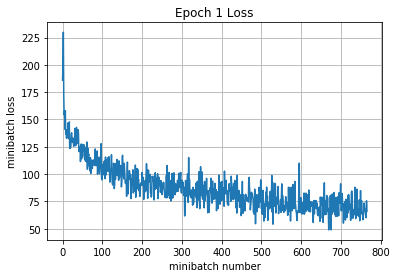

Iteration 800: with minibatch training loss = 1.04 and accuracy of 0.62
Iteration 900: with minibatch training loss = 1.12 and accuracy of 0.66
Iteration 1000: with minibatch training loss = 0.765 and accuracy of 0.73
Iteration 1100: with minibatch training loss = 0.902 and accuracy of 0.7
Iteration 1200: with minibatch training loss = 0.96 and accuracy of 0.61
Iteration 1300: with minibatch training loss = 1.12 and accuracy of 0.52
Iteration 1400: with minibatch training loss = 0.843 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 0.743 and accuracy of 0.75
Epoch 2, Overall loss = 0.933 and accuracy of 0.671


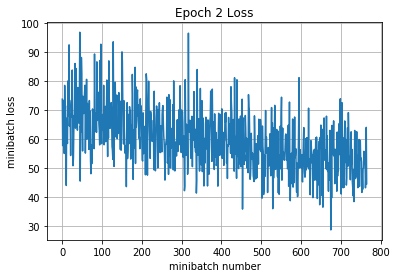

Iteration 1600: with minibatch training loss = 0.969 and accuracy of 0.75
Iteration 1700: with minibatch training loss = 0.717 and accuracy of 0.8
Iteration 1800: with minibatch training loss = 0.831 and accuracy of 0.64
Iteration 1900: with minibatch training loss = 0.607 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.935 and accuracy of 0.7
Iteration 2100: with minibatch training loss = 0.783 and accuracy of 0.7
Iteration 2200: with minibatch training loss = 0.59 and accuracy of 0.77
Epoch 3, Overall loss = 0.748 and accuracy of 0.741


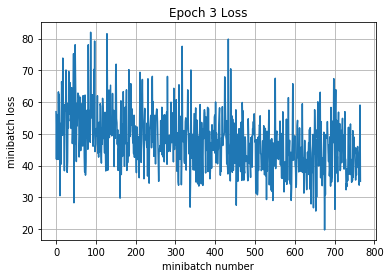

Iteration 2300: with minibatch training loss = 0.743 and accuracy of 0.72
Iteration 2400: with minibatch training loss = 0.56 and accuracy of 0.81
Iteration 2500: with minibatch training loss = 0.417 and accuracy of 0.86
Iteration 2600: with minibatch training loss = 0.857 and accuracy of 0.72
Iteration 2700: with minibatch training loss = 0.468 and accuracy of 0.8
Iteration 2800: with minibatch training loss = 0.445 and accuracy of 0.84
Iteration 2900: with minibatch training loss = 0.548 and accuracy of 0.84
Iteration 3000: with minibatch training loss = 0.713 and accuracy of 0.77
Epoch 4, Overall loss = 0.616 and accuracy of 0.789


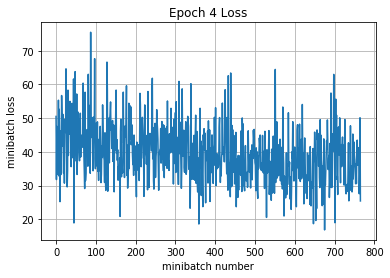

Iteration 3100: with minibatch training loss = 0.643 and accuracy of 0.77
Iteration 3200: with minibatch training loss = 0.638 and accuracy of 0.73
Iteration 3300: with minibatch training loss = 0.653 and accuracy of 0.78
Iteration 3400: with minibatch training loss = 0.468 and accuracy of 0.8
Iteration 3500: with minibatch training loss = 0.514 and accuracy of 0.81
Iteration 3600: with minibatch training loss = 0.363 and accuracy of 0.86
Iteration 3700: with minibatch training loss = 0.428 and accuracy of 0.84
Iteration 3800: with minibatch training loss = 0.369 and accuracy of 0.84
Epoch 5, Overall loss = 0.511 and accuracy of 0.824


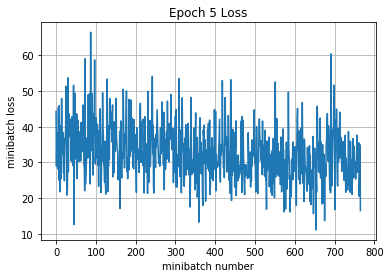

Iteration 3900: with minibatch training loss = 0.354 and accuracy of 0.91
Iteration 4000: with minibatch training loss = 0.567 and accuracy of 0.77
Iteration 4100: with minibatch training loss = 0.335 and accuracy of 0.86
Iteration 4200: with minibatch training loss = 0.561 and accuracy of 0.84
Iteration 4300: with minibatch training loss = 0.443 and accuracy of 0.84
Iteration 4400: with minibatch training loss = 0.561 and accuracy of 0.84
Iteration 4500: with minibatch training loss = 0.439 and accuracy of 0.89
Epoch 6, Overall loss = 0.433 and accuracy of 0.851


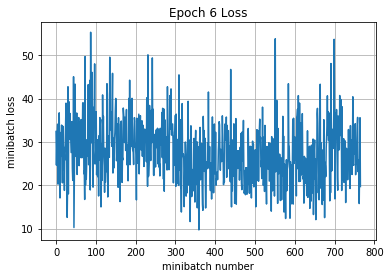

Iteration 4600: with minibatch training loss = 0.544 and accuracy of 0.81
Iteration 4700: with minibatch training loss = 0.357 and accuracy of 0.86
Iteration 4800: with minibatch training loss = 0.447 and accuracy of 0.83
Iteration 4900: with minibatch training loss = 0.207 and accuracy of 0.92
Iteration 5000: with minibatch training loss = 0.33 and accuracy of 0.88
Iteration 5100: with minibatch training loss = 0.265 and accuracy of 0.89
Iteration 5200: with minibatch training loss = 0.217 and accuracy of 0.92
Iteration 5300: with minibatch training loss = 0.544 and accuracy of 0.77
Epoch 7, Overall loss = 0.377 and accuracy of 0.868


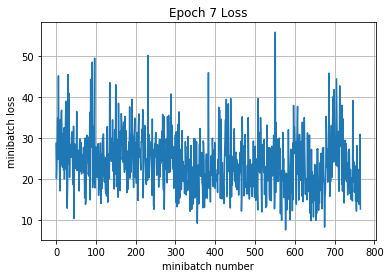

Iteration 5400: with minibatch training loss = 0.383 and accuracy of 0.88
Iteration 5500: with minibatch training loss = 0.374 and accuracy of 0.89
Iteration 5600: with minibatch training loss = 0.34 and accuracy of 0.88
Iteration 5700: with minibatch training loss = 0.181 and accuracy of 0.94
Iteration 5800: with minibatch training loss = 0.158 and accuracy of 0.95
Iteration 5900: with minibatch training loss = 0.289 and accuracy of 0.94
Iteration 6000: with minibatch training loss = 0.181 and accuracy of 0.94
Iteration 6100: with minibatch training loss = 0.314 and accuracy of 0.91
Epoch 8, Overall loss = 0.306 and accuracy of 0.893


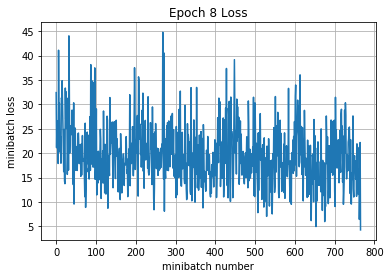

Iteration 6200: with minibatch training loss = 0.217 and accuracy of 0.92
Iteration 6300: with minibatch training loss = 0.26 and accuracy of 0.92
Iteration 6400: with minibatch training loss = 0.229 and accuracy of 0.94
Iteration 6500: with minibatch training loss = 0.106 and accuracy of 0.97
Iteration 6600: with minibatch training loss = 0.187 and accuracy of 0.92
Iteration 6700: with minibatch training loss = 0.232 and accuracy of 0.95
Iteration 6800: with minibatch training loss = 0.238 and accuracy of 0.91
Epoch 9, Overall loss = 0.235 and accuracy of 0.918


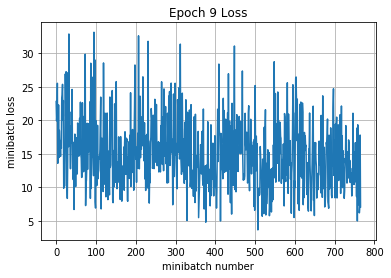

Iteration 6900: with minibatch training loss = 0.278 and accuracy of 0.89
Iteration 7000: with minibatch training loss = 0.246 and accuracy of 0.91
Iteration 7100: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 7200: with minibatch training loss = 0.203 and accuracy of 0.91
Iteration 7300: with minibatch training loss = 0.166 and accuracy of 0.94
Iteration 7400: with minibatch training loss = 0.208 and accuracy of 0.92
Iteration 7500: with minibatch training loss = 0.406 and accuracy of 0.88
Iteration 7600: with minibatch training loss = 0.133 and accuracy of 0.95
Epoch 10, Overall loss = 0.2 and accuracy of 0.929


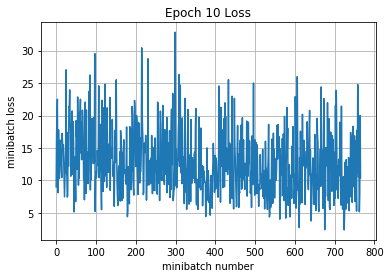

Iteration 7700: with minibatch training loss = 0.228 and accuracy of 0.89
Iteration 7800: with minibatch training loss = 0.197 and accuracy of 0.91
Iteration 7900: with minibatch training loss = 0.112 and accuracy of 0.97
Iteration 8000: with minibatch training loss = 0.357 and accuracy of 0.84
Iteration 8100: with minibatch training loss = 0.149 and accuracy of 0.94
Iteration 8200: with minibatch training loss = 0.066 and accuracy of 0.97
Iteration 8300: with minibatch training loss = 0.182 and accuracy of 0.92
Iteration 8400: with minibatch training loss = 0.166 and accuracy of 0.95
Epoch 11, Overall loss = 0.169 and accuracy of 0.941


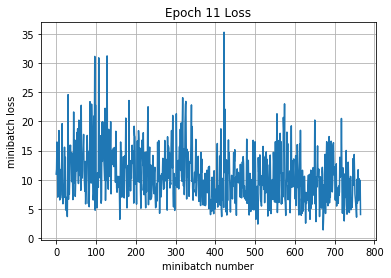

Iteration 8500: with minibatch training loss = 0.103 and accuracy of 0.95
Iteration 8600: with minibatch training loss = 0.135 and accuracy of 0.94
Iteration 8700: with minibatch training loss = 0.112 and accuracy of 0.95
Iteration 8800: with minibatch training loss = 0.184 and accuracy of 0.92
Iteration 8900: with minibatch training loss = 0.12 and accuracy of 0.92
Iteration 9000: with minibatch training loss = 0.173 and accuracy of 0.91
Iteration 9100: with minibatch training loss = 0.0986 and accuracy of 0.95
Epoch 12, Overall loss = 0.139 and accuracy of 0.951


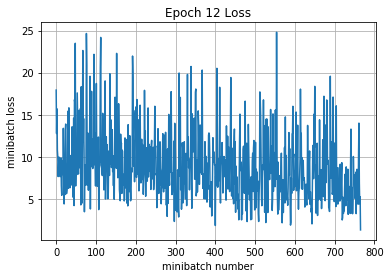

Iteration 9200: with minibatch training loss = 0.0858 and accuracy of 0.97
Iteration 9300: with minibatch training loss = 0.0742 and accuracy of 0.98
Iteration 9400: with minibatch training loss = 0.0448 and accuracy of 1
Iteration 9500: with minibatch training loss = 0.0767 and accuracy of 0.98
Iteration 9600: with minibatch training loss = 0.212 and accuracy of 0.91
Iteration 9700: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 9800: with minibatch training loss = 0.17 and accuracy of 0.95
Iteration 9900: with minibatch training loss = 0.185 and accuracy of 0.94
Epoch 13, Overall loss = 0.121 and accuracy of 0.957


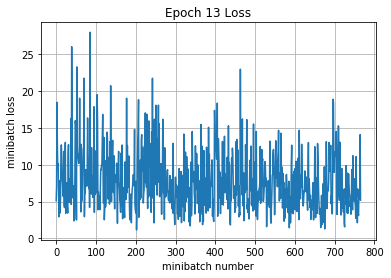

Iteration 10000: with minibatch training loss = 0.0837 and accuracy of 0.98
Iteration 10100: with minibatch training loss = 0.0626 and accuracy of 0.97
Iteration 10200: with minibatch training loss = 0.0778 and accuracy of 0.98
Iteration 10300: with minibatch training loss = 0.0734 and accuracy of 0.97
Iteration 10400: with minibatch training loss = 0.154 and accuracy of 0.97
Iteration 10500: with minibatch training loss = 0.1 and accuracy of 0.97
Iteration 10600: with minibatch training loss = 0.204 and accuracy of 0.92
Iteration 10700: with minibatch training loss = 0.0549 and accuracy of 0.97
Epoch 14, Overall loss = 0.102 and accuracy of 0.965


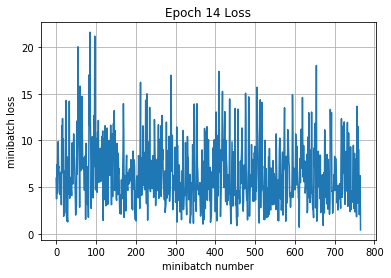

Iteration 10800: with minibatch training loss = 0.131 and accuracy of 0.95
Iteration 10900: with minibatch training loss = 0.0904 and accuracy of 0.97
Iteration 11000: with minibatch training loss = 0.0978 and accuracy of 0.97
Iteration 11100: with minibatch training loss = 0.095 and accuracy of 0.97
Iteration 11200: with minibatch training loss = 0.0352 and accuracy of 0.98
Iteration 11300: with minibatch training loss = 0.0769 and accuracy of 0.98
Iteration 11400: with minibatch training loss = 0.0901 and accuracy of 0.97
Epoch 15, Overall loss = 0.0802 and accuracy of 0.972


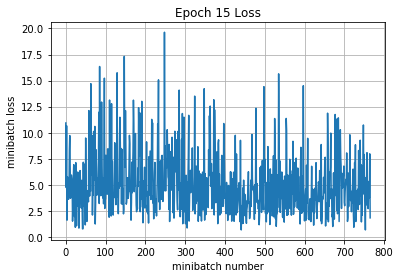

Validation
Epoch 1, Overall loss = 1.26 and accuracy of 0.755


(1.2581371040344238, 0.755)

In [20]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
# run_model(session, predict, loss_val, Xd, yd, epochs=1, batch_size=64, 
# print_every=100, training=None, plot_losses=False)
print(X_train.shape, y_train.shape)
run_model(sess,y_out,mean_loss,X_train,y_train,15,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [21]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.118 and accuracy of 0.959
Validation
Epoch 1, Overall loss = 1.28 and accuracy of 0.755


(1.276570957183838, 0.755)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

I tried the following:
1. 
conv(100 filters 3x3)-relu-bn 
conv(200 filters 3x3)-relu-bn 
conv(200 filters 3x3)-relu-bn 
maxpool 2x2 
affine-relu-affine
2. more true to the paper linked: https://arxiv.org/pdf/1412.6806.pdf
conv(96 filters 3x3)-relu-bn 
conv(192 filters 3x3)-relu-bn 
conv(192 filters 3x3)-relu-bn 
maxpool 2x2 
affine-relu-affine
3. I added dropout regularization, but it turned out that it wasn't actually useful!
4. I switched batchnorm with relu to get better results.
5. I did maxpools after each convolution instead of at the end and that improved results.
6. The big game changer was changing the strides of the convolutions from 2 to 1. That made the accuracy go up considerably...I think the network wasn't complex enough without that. 
7. I increased the number of epochs to 15. 
8. The unique thing that I did apart from the paper's recommendations was experiment with dropout and stride. 


### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [ ]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable. ANSWER: The unique thing that I did apart from the paper's recommendations was experiment with dropout and stride. 